In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! mkdir /content/kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d paultimothymooney/breast-histopathology-images
!unzip -q /content/breast-histopathology-images.zip -d /content/kaggle/
!rm /content/breast-histopathology-images.zip


Saving kaggle.json to kaggle.json
100% 3.10G/3.10G [02:33<00:00, 21.7MB/s]
100% 3.10G/3.10G [02:33<00:00, 21.7MB/s]


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#import libraries
import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pylab as plt
import keras.backend as K
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16
%matplotlib inline
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [4]:
#load the dataset
imagePatches = glob('/content/kaggle/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

/content/kaggle/9345/0/9345_idx5_x2001_y1551_class0.png
/content/kaggle/9345/0/9345_idx5_x1251_y2801_class0.png
/content/kaggle/9345/0/9345_idx5_x1851_y2701_class0.png
/content/kaggle/9345/0/9345_idx5_x1301_y2351_class0.png
/content/kaggle/9345/0/9345_idx5_x901_y2501_class0.png
/content/kaggle/9345/0/9345_idx5_x551_y2551_class0.png
/content/kaggle/9345/0/9345_idx5_x1451_y2651_class0.png
/content/kaggle/9345/0/9345_idx5_x2351_y1601_class0.png
/content/kaggle/9345/0/9345_idx5_x851_y2701_class0.png
/content/kaggle/9345/0/9345_idx5_x2301_y2001_class0.png


In [5]:
# Two arrays holding images by class type

class0 = [] # 0 = no cancer
class1 = [] # 1 = cancer

for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)
sampled_class0 = class0[50000:60000]
sampled_class1 = class1[50000:60000]
len(sampled_class0)
img_size = 75
from matplotlib.image import imread
import cv2

def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
        if i.endswith('.png'):
            img = cv2.imread(i ,cv2.IMREAD_COLOR)
            img_sized = cv2.resize(img, (img_size,img_size), interpolation=cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label])
    return img_arrays

class0_array = get_image_arrays(sampled_class0, 0)
class1_array = get_image_arrays(sampled_class1, 1)
# Combine the class arrays
combined_data = np.concatenate((np.array(class0_array, dtype=object), np.array(class1_array, dtype=object)))
#data splitting
X = []
y = []

for features,label in combined_data:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1, img_size, img_size, 3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5000, 75, 75, 3) (15000, 75, 75, 3) (5000, 2) (15000, 2)


In [82]:
from keras.models import load_model
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

# these models were trained on 5 separate subsets of the data (for bagging ensemble)
MSDmodel = load_model('/content/drive/MyDrive/To toba /shuffled models/densenetmodel.hdf5', compile=False)
MSMmodel = load_model('/content/drive/MyDrive/To toba /shuffled models/mobilenetmodel.hdf5', compile=False)
MSRmodel = load_model('/content/drive/MyDrive/To toba /shuffled models/resnet50model.hdf5', compile=False)
MSVmodel = load_model('/content/drive/MyDrive/To toba /shuffled models/vgg16model.hdf5', compile=False)
MSXmodel = load_model('/content/drive/MyDrive/To toba /shuffled models/xceptionmodel.hdf5', compile=False)


MSpred_model1 = MSDmodel.predict(X_test) # dense
MSpred_model2 = MSMmodel.predict(X_test) # mobile net
MSpred_model3 = MSRmodel.predict(X_test) # mobile net
MSpred_model4 = MSVmodel.predict(X_test) # VGG16
MSpred_model5 = MSXmodel.predict(X_test) # xception


469/469 [==============================] - 9s 17ms/step


In [83]:
from keras.models import load_model
import numpy as np
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

# these models were trained on the exact same subset of the dataset (for bagging ensemble)
SSDmodel = load_model('/content/drive/MyDrive/To toba /nonshuffled models/densenetmodel.hdf5', compile=False)
SSMmodel = load_model('/content/drive/MyDrive/To toba /nonshuffled models/mobilenetmodel.hdf5', compile=False)
SSRmodel = load_model('/content/drive/MyDrive/To toba /nonshuffled models/resnet50model.hdf5', compile=False)
SSVmodel = load_model('/content/drive/MyDrive/To toba /nonshuffled models/vgg16model.hdf5', compile=False)
SSXmodel = load_model('/content/drive/MyDrive/To toba /nonshuffled models/xceptionmodel.hdf5', compile=False)

# Predict using each base model
SSpred_model1 = SSDmodel.predict(X_test)
SSpred_model2 = SSMmodel.predict(X_test)
SSpred_model3 = SSRmodel.predict(X_test)
SSpred_model4 = SSVmodel.predict(X_test)
SSpred_model5 = SSXmodel.predict(X_test)


469/469 [==============================] - 9s 18ms/step


In [84]:
multi_subset_data_model_predictions = [MSpred_model1, MSpred_model2,MSpred_model3, MSpred_model4, MSpred_model5] # predictions with separate data
single_subset_data_model_predictions = [SSpred_model1, SSpred_model2,SSpred_model3,SSpred_model4, SSpred_model5] # predictions with the same data

In [85]:
def most_frequent(List):
    """
    This is a function to get the most
    recurring item in a list
    """
    counter = 0
    num = List[0]

    for i in List:
        curr_frequency = List.count(i)
        if(curr_frequency> counter):
            counter = curr_frequency
            num = i
    return num

def max_voting(model_predictions):
  """
  This is a function to calculate the max voting ensemble model,
  it collects a list of predictions from diffent models as input, then
  calculate the class with the highest confidence from each of the models
  and uses that to get the output for the final prediction.
  """
  predictions =[]
  for i in range(len(model_predictions[0])):
    preds =[]
    for n in range(5):
      a = model_predictions[n][i]  # Can be of any shape
      indices = np.where(a == a.max())
      # Extract the numerical value from the NumPy array
      number = indices[0][0]
      preds.append(number)
    pred = most_frequent(preds)
    predictions.append(pred)
    # Convert the list to a NumPy array
  predictions = np.array(predictions)
  return predictions


In [86]:
def averaging(model_predictions):
  """
  This is a function to calculate the averaging ensemble model,
  it collects a list of predictions from diffent models as input, then
  calculate the  class with the average confidence from each from each model
  and uses that to get the output for the final prediction.
  """
  predictions =[]
  for i in range(len(model_predictions[0])):
    zeros_ =[]
    ones_ = []
    for n in range(5):
      a,b = model_predictions[n][i]  # Can be of any shape
      zeros_.append(a)
      ones_.append(b)
    average_zeros = np.average(zeros_, axis=0)
    average_ones = np.average(ones_, axis=0)
    if average_ones > average_zeros:
      predictions.append(1)
    elif average_zeros > average_ones:
      predictions.append(0)
  predictions = np.array(predictions)
  return predictions


In [87]:
def weighted_average(model_predictions, weights):
  """
  This is a function to calculate the weighted average ensemble model,
  it collects a list of predictions from diffent models as input, then
  calculate the  class with the average confidence from each from each
  model based on the models weight and uses that to get the output for
  the final prediction.
  """
  predictions =[]
  for i in range(len(model_predictions[0])):
    zeros_ =[]
    ones_ = []
    for n in range(5):
      a,b = model_predictions[n][i]  # Can be of any shape
      zeros_.append(a)
      ones_.append(b)
    average_zeros = np.average(zeros_, axis=0, weights=weights)
    average_ones = np.average(ones_, axis=0, weights=weights)
    if average_ones > average_zeros:
      predictions.append(1)
    elif average_zeros > average_ones:
      predictions.append(0)
  predictions = np.array(predictions)
  return predictions


In [88]:
def bagging(model_predictions):
  '''
    The bagging ensemble is gotten from the use of separate subets of the the dataset\
    to train each of the models, the Smodel_predictions list holds the models that\
    were trained on these datasets and will be used with either max voting or averaging
  '''
  bagging_voting = max_voting(model_predictions)
  bagging_averaging = averaging(model_predictions)
  return (bagging_voting, bagging_averaging)

In [89]:
import sklearn.metrics as metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix
def calculate_metrics2(predictions, ground_truth):
    # Convert predictions to binary

    # Calculate evaluation metrics
    accuracy = metrics.accuracy_score(ground_truth, predictions)
    precision = metrics.precision_score(ground_truth, predictions)
    recall = metrics.recall_score(ground_truth, predictions)
    f1_score = metrics.f1_score(ground_truth, predictions)
    # Generate confusion matrix plot
    confusion_mtx = confusion_matrix(ground_truth, predictions)

    # Calculate normalized confusion matrix
    confusion_mtx_normalized = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

    # Convert to percentage format
    confusion_mtx_normalized_percentage = confusion_mtx_normalized * 100

    # Plot the normalized confusion matrix with percentage values
    f, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx_normalized_percentage, annot=True, linewidths=0.01, cmap="OrRd", linecolor="black", fmt='.2f', ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Normalized Confusion Matrix (%)")
    plt.show()
    return accuracy, precision, recall, f1_score, confusion_matrix

In [90]:
# Ensemble Predictions

weights = [0.85, 0.76,0.83 , 0.81, 0.81] # weights gotten from the accuracy of the initial training of the models

max_voting_predictions = max_voting(single_subset_data_model_predictions)
averaging_predictions = averaging(single_subset_data_model_predictions)
weighted_average_predictions = weighted_average(single_subset_data_model_predictions, weights)
bagging_ensemble1, bagging_ensemble2 = bagging(multi_subset_data_model_predictions)

In [91]:
Y_true = np.argmax(y_test,axis = 1)
Y_true

array([1, 0, 0, ..., 0, 1, 1])

In [ ]:

# Define the ensemble method names and metrics
ensemble_names = ['max_voting_predictions', 'averaging_predictions', 'weighted_average_predictions', 'bagging_max_voting', 'bagging_weighted_averaging']
metrics = ['Accuracy', 'Precision', 'Recall']
# Define the ensemble method names and metrics
max_voting_predictions1 = []  # Accuracy, Precision, Recall
averaging_predictions1 = [] # Accuracy, Precision, Recall
weighted_average_predictions1 = []  # Accuracy, Precision, Recall
bagging_max_voting1 = []  # Accuracy, Precision, Recall
bagging_weighted_averaging1 = []  # Accuracy, Precision, Recall

In [103]:
accuracy =[]
precision = []
recall = []
ensemble_names = ['max_voting_predictions', 'averaging_predictions', 'weighted_average_predictions', 'bagging_max_voting', 'bagging_weighted_averaging']

In [104]:
import numpy as np
import matplotlib.pyplot as plt
print(max_voting_predictions)



[1 0 0 ... 0 1 0]


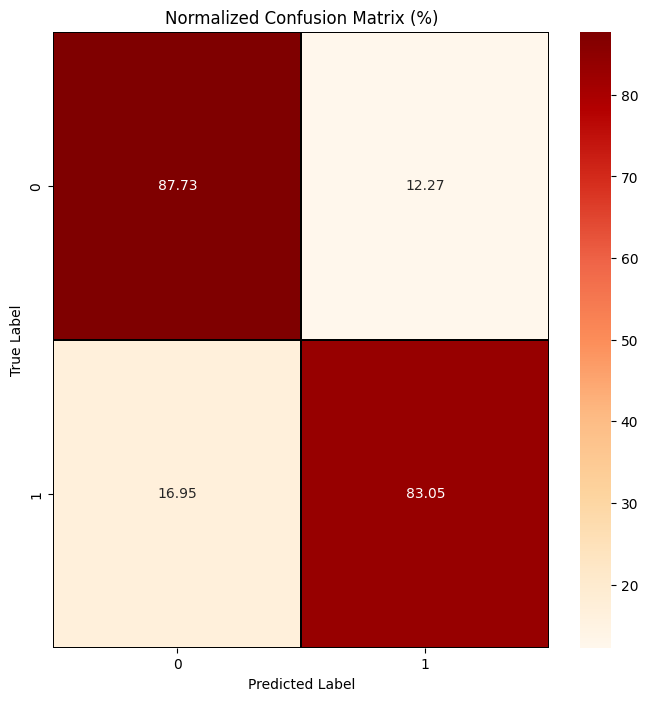

Max Voting Ensemble Accuracy: 0.8540666666666666
Max Voting Ensemble Precision: 0.8698524244553759
Max Voting Ensemble Recall: 0.8305152979066023
Max Voting Ensemble F1 Score: 0.8497288391569986
Max Voting Ensemble Confusion Matrix:
<function confusion_matrix at 0x787921c835b0>
-------------------------------


In [105]:
# Define a function to calculate evaluation metrics

# Calculate evaluation metrics for the given predictions
max_voting_accuracy, max_voting_precision, max_voting_recall, max_voting_f1, max_voting_confusion_matrix = calculate_metrics2(max_voting_predictions, Y_true)
# Print the evaluation metrics
accuracy.append(max_voting_accuracy)
precision.append(max_voting_precision)
recall.append(max_voting_recall)
print("Max Voting Ensemble Accuracy:", max_voting_accuracy)

print("Max Voting Ensemble Precision:", max_voting_precision)

print("Max Voting Ensemble Recall:", max_voting_recall)

print("Max Voting Ensemble F1 Score:", max_voting_f1)
print("Max Voting Ensemble Confusion Matrix:")
print(max_voting_confusion_matrix)
print("-------------------------------")

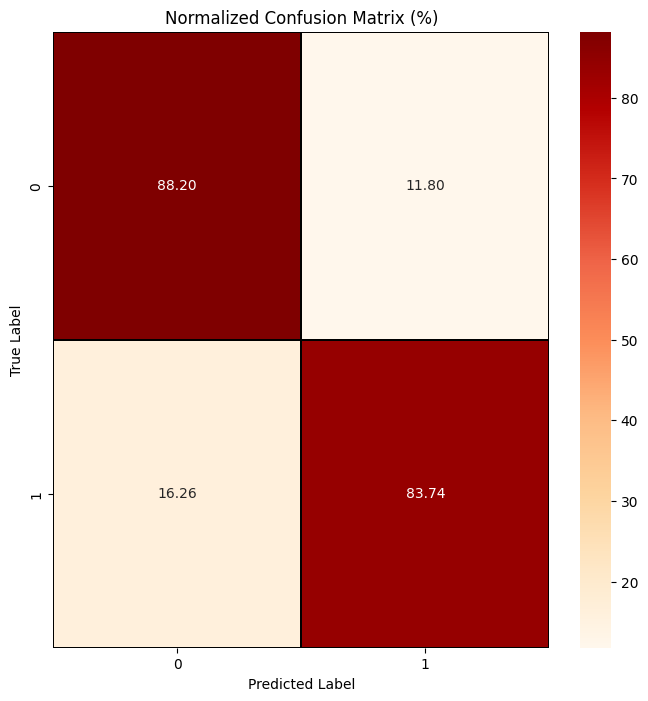

Averaging Ensemble Accuracy: 0.8598
Averaging Ensemble Precision: 0.8750525872949095
Averaging Ensemble Recall: 0.8373590982286635
Averaging Ensemble F1 Score: 0.8557909895083318
Averaging Ensemble Confusion Matrix:
<function confusion_matrix at 0x787921c835b0>
-------------------------------


In [106]:
import numpy as np
import sklearn.metrics as metrics
import seaborn as sns


averaging_accuracy, averaging_precision, averaging_recall, averaging_f1, averaging_confusion_matrix = calculate_metrics2(averaging_predictions, Y_true)
accuracy.append(averaging_accuracy)
precision.append(averaging_precision)
recall.append(averaging_recall)
print("Averaging Ensemble Accuracy:", averaging_accuracy)
print("Averaging Ensemble Precision:", averaging_precision)
print("Averaging Ensemble Recall:", averaging_recall)
print("Averaging Ensemble F1 Score:", averaging_f1)
print("Averaging Ensemble Confusion Matrix:")
print(averaging_confusion_matrix)
print("-------------------------------")

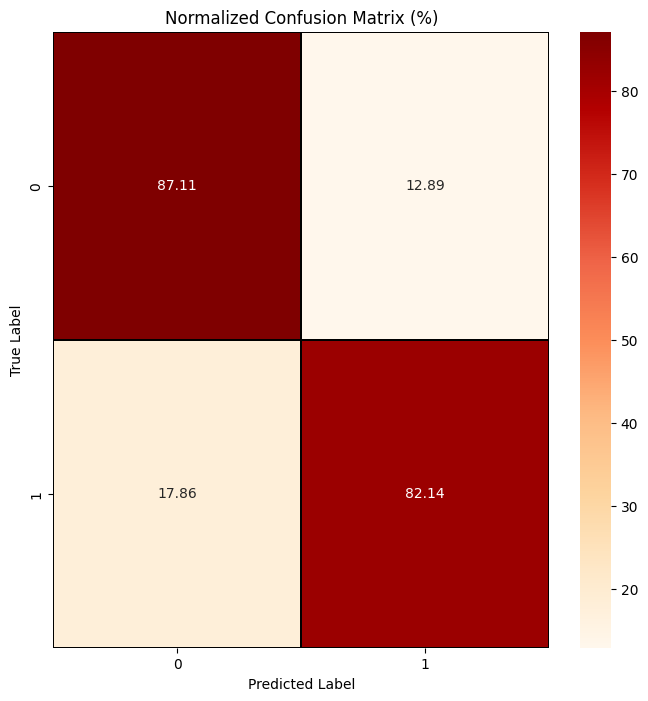

Bagging Ensemble using max voting Accuracy: 0.8464
Bagging Ensemble using max voting Precision: 0.862841838173104
Bagging Ensemble using max voting Recall: 0.8213902308105206
Bagging Ensemble using max voting F1 Score: 0.8416059397772583
Bagging Ensemble using max voting Confusion Matrix:
<function confusion_matrix at 0x787921c835b0>
-------------------------------


In [107]:

bagging_accuracy, bagging_precision, bagging_recall, bagging_f1, bagging_confusion_matrix = calculate_metrics2(bagging_ensemble1, Y_true)
accuracy.append(bagging_accuracy)
precision.append(bagging_precision)
recall.append(bagging_recall)
print("Bagging Ensemble using max voting Accuracy:", bagging_accuracy)
print("Bagging Ensemble using max voting Precision:", bagging_precision)
print("Bagging Ensemble using max voting Recall:", bagging_recall)
print("Bagging Ensemble using max voting F1 Score:", bagging_f1)
print("Bagging Ensemble using max voting Confusion Matrix:")
print(bagging_confusion_matrix)
print("-------------------------------")

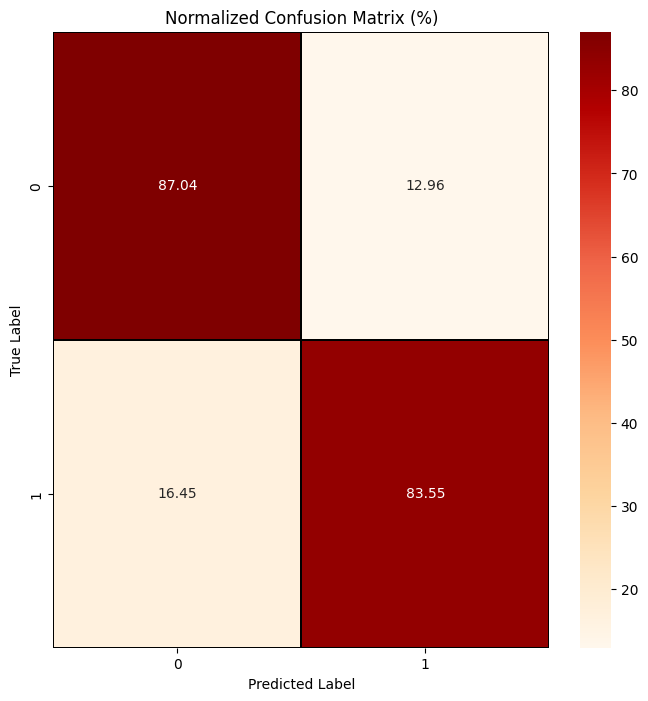

Bagging Ensemble using averaging Accuracy: 0.8530666666666666
Bagging Ensemble using averaging Precision: 0.8642420877290394
Bagging Ensemble using averaging Recall: 0.8354804079441761
Bagging Ensemble using averaging F1 Score: 0.849617903930131
Bagging Ensemble using averaging Confusion Matrix:
<function confusion_matrix at 0x787921c835b0>
-------------------------------


In [108]:

bagging_accuracy, bagging_precision, bagging_recall, bagging_f1, bagging_confusion_matrix = calculate_metrics2(bagging_ensemble2, Y_true)
accuracy.append(bagging_accuracy)
precision.append(bagging_precision)
recall.append(bagging_recall)
print("Bagging Ensemble using averaging Accuracy:", bagging_accuracy)
print("Bagging Ensemble using averaging Precision:", bagging_precision)
print("Bagging Ensemble using averaging Recall:", bagging_recall)
print("Bagging Ensemble using averaging F1 Score:", bagging_f1)
print("Bagging Ensemble using averaging Confusion Matrix:")
print(bagging_confusion_matrix)
print("-------------------------------")

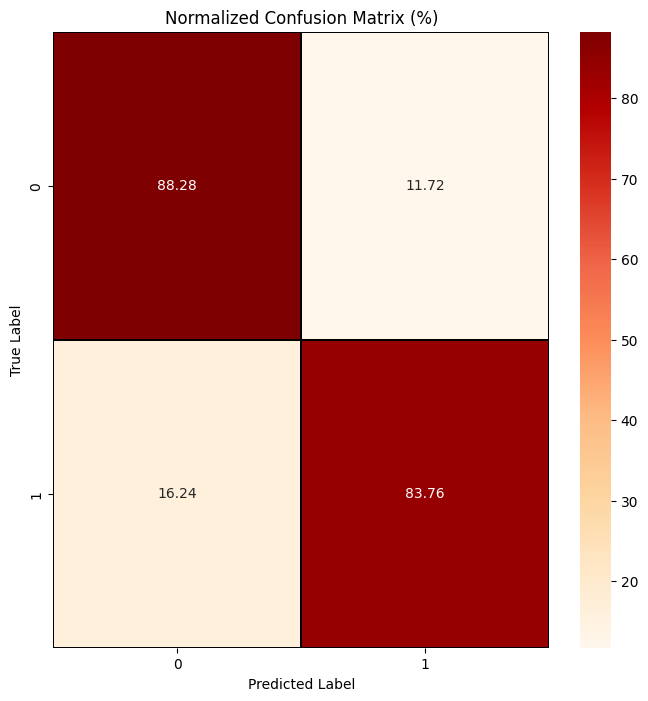

weighted Ensemble Accuracy: 0.8603333333333333
weighted Ensemble Precision: 0.875824330012628
weighted Ensemble Recall: 0.8376274825550187
weighted Ensemble F1 Score: 0.8563001577611632
weighted Ensemble Confusion Matrix:
<function confusion_matrix at 0x787921c835b0>
-------------------------------


In [109]:


boosting_accuracy, boosting_precision, boosting_recall, boosting_f1, boosting_confusion_matrix = calculate_metrics2(weighted_average_predictions, Y_true)
accuracy.append(boosting_accuracy)
precision.append(boosting_precision)
recall.append(boosting_recall)
print("weighted Ensemble Accuracy:", boosting_accuracy)
print("weighted Ensemble Precision:", boosting_precision)
print("weighted Ensemble Recall:", boosting_recall)
print("weighted Ensemble F1 Score:", boosting_f1)
print("weighted Ensemble Confusion Matrix:")
print(boosting_confusion_matrix)
print("-------------------------------")

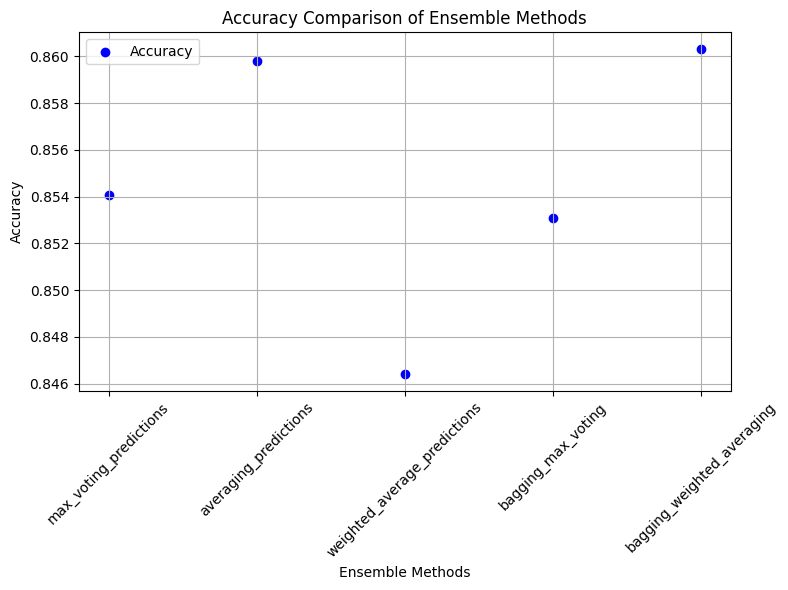

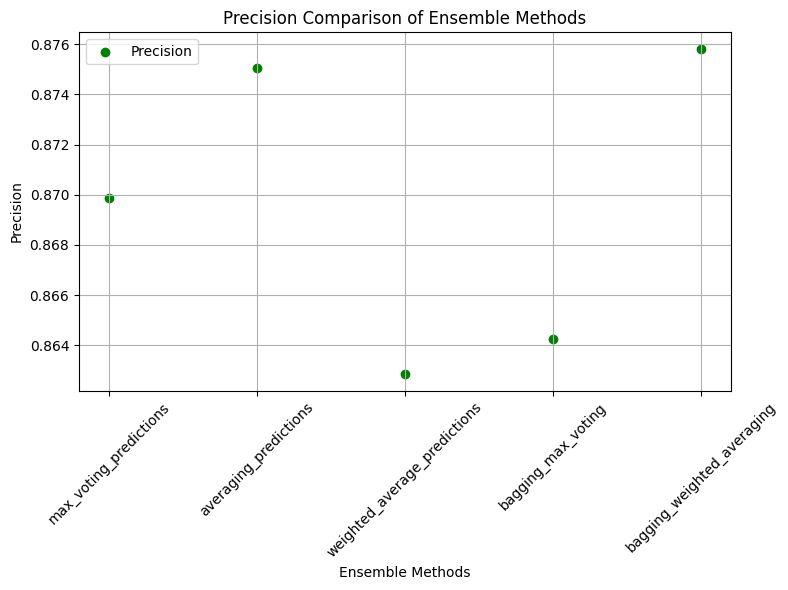

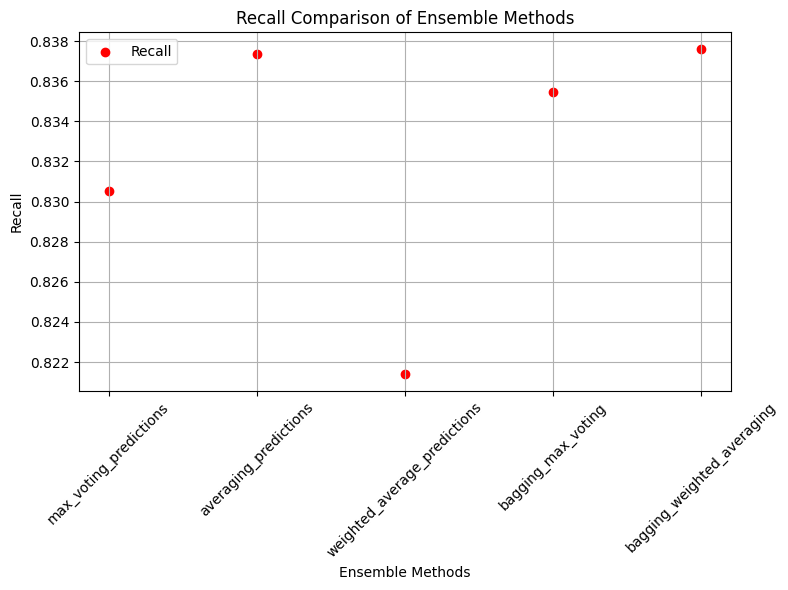

In [112]:


# Create a scatter plot for accuracy
plt.figure(figsize=(8, 6))
plt.scatter(ensemble_names, accuracy, color='blue', label='Accuracy')
plt.xlabel('Ensemble Methods')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Ensemble Methods')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a scatter plot for precision
plt.figure(figsize=(8, 6))
plt.scatter(ensemble_names, precision, color='green', label='Precision')
plt.xlabel('Ensemble Methods')
plt.ylabel('Precision')
plt.title('Precision Comparison of Ensemble Methods')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a scatter plot for recall
plt.figure(figsize=(8, 6))
plt.scatter(ensemble_names, recall, color='red', label='Recall')
plt.xlabel('Ensemble Methods')
plt.ylabel('Recall')
plt.title('Recall Comparison of Ensemble Methods')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()